In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from src.plots import (
    plot_distribution,
    draw_plots_grid,
    plot_bivariate_distribution
)
from src.data_engineering import (
    calculate_rolling_baselines, 
    add_risk_scores,
    engineer_target_variable
)
from src.data_cleaning import create_merged_dfs(participant_id)

from statsmodels.tsa.stattools import adfuller  


In [2]:
df = pd.read_csv("./cleaned_data/many_participants.csv", )
df.set_index("dateTime", inplace = True)

In [3]:
p07 = df[df["participant_id"] == "p07"]
p07.iloc[:,[1,2,7,8]]

,resting_heart_rate,avg_overall_sleep_score,very_active_minutes_sum,sedentary_minutes_sum
dateTime,,,,
2019-11-21,55.481817,84.0,94,517
2019-11-22,57.737835,67.0,9,830
2019-11-23,56.930720,85.0,30,623
2019-11-24,59.165880,48.0,86,855
2019-11-25,56.551208,89.0,49,537
...,...,...,...,...
2020-03-27,58.138510,76.0,15,350
2020-03-28,57.808391,81.0,9,467
2020-03-29,57.808391,81.0,0,1325


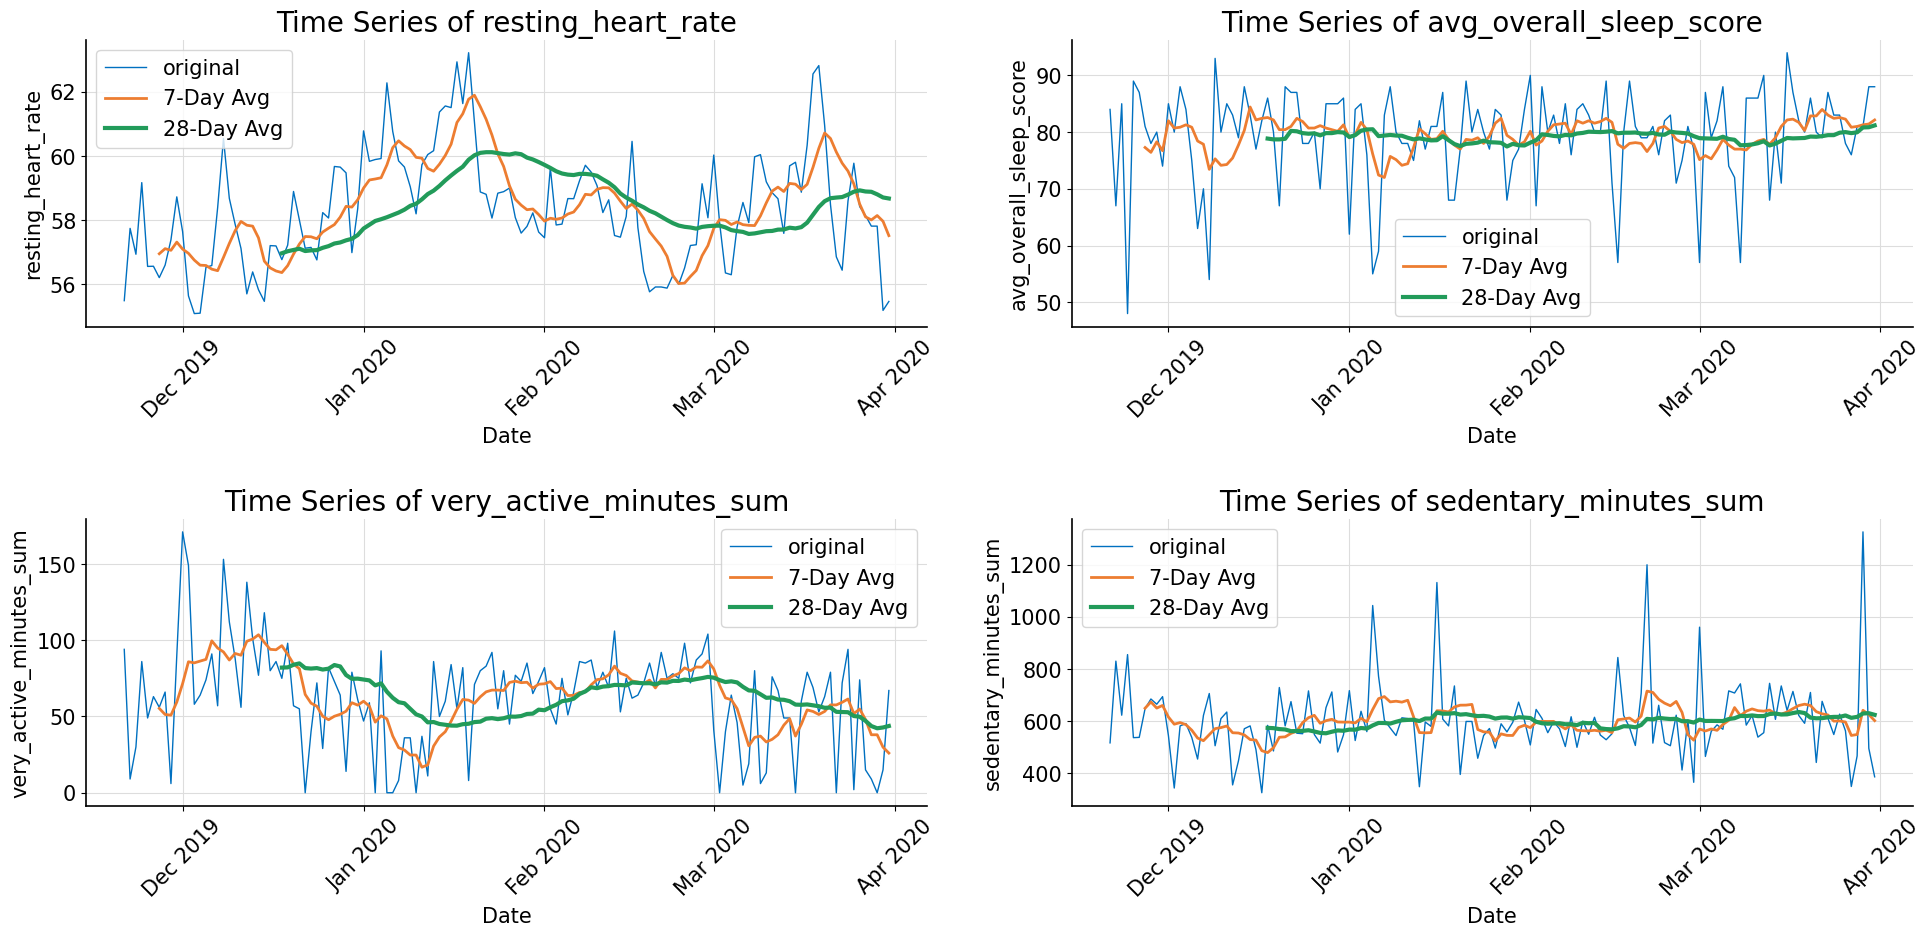

In [4]:
draw_plots_grid(
    p07.iloc[:, [1,2,7,8]],
    p07.iloc[:, [1,2,7,8]].columns,
    windows        = [7, 28],                # keep your two smoothers
    figure_size    = (20, 10),               # good for PPT 16:9 (≈1920×1080)
    nrows          = 2,
    ncols          = 2,
    title_fontsize = 20,                     
    label_fontsize = 15,                     # axis labels
    tick_fontsize  = 15,                     # tick labels
    legend_fontsize= 15,                     # legend text
    save_path      = "./figures/2025-06-23_timeseries.svg"
)

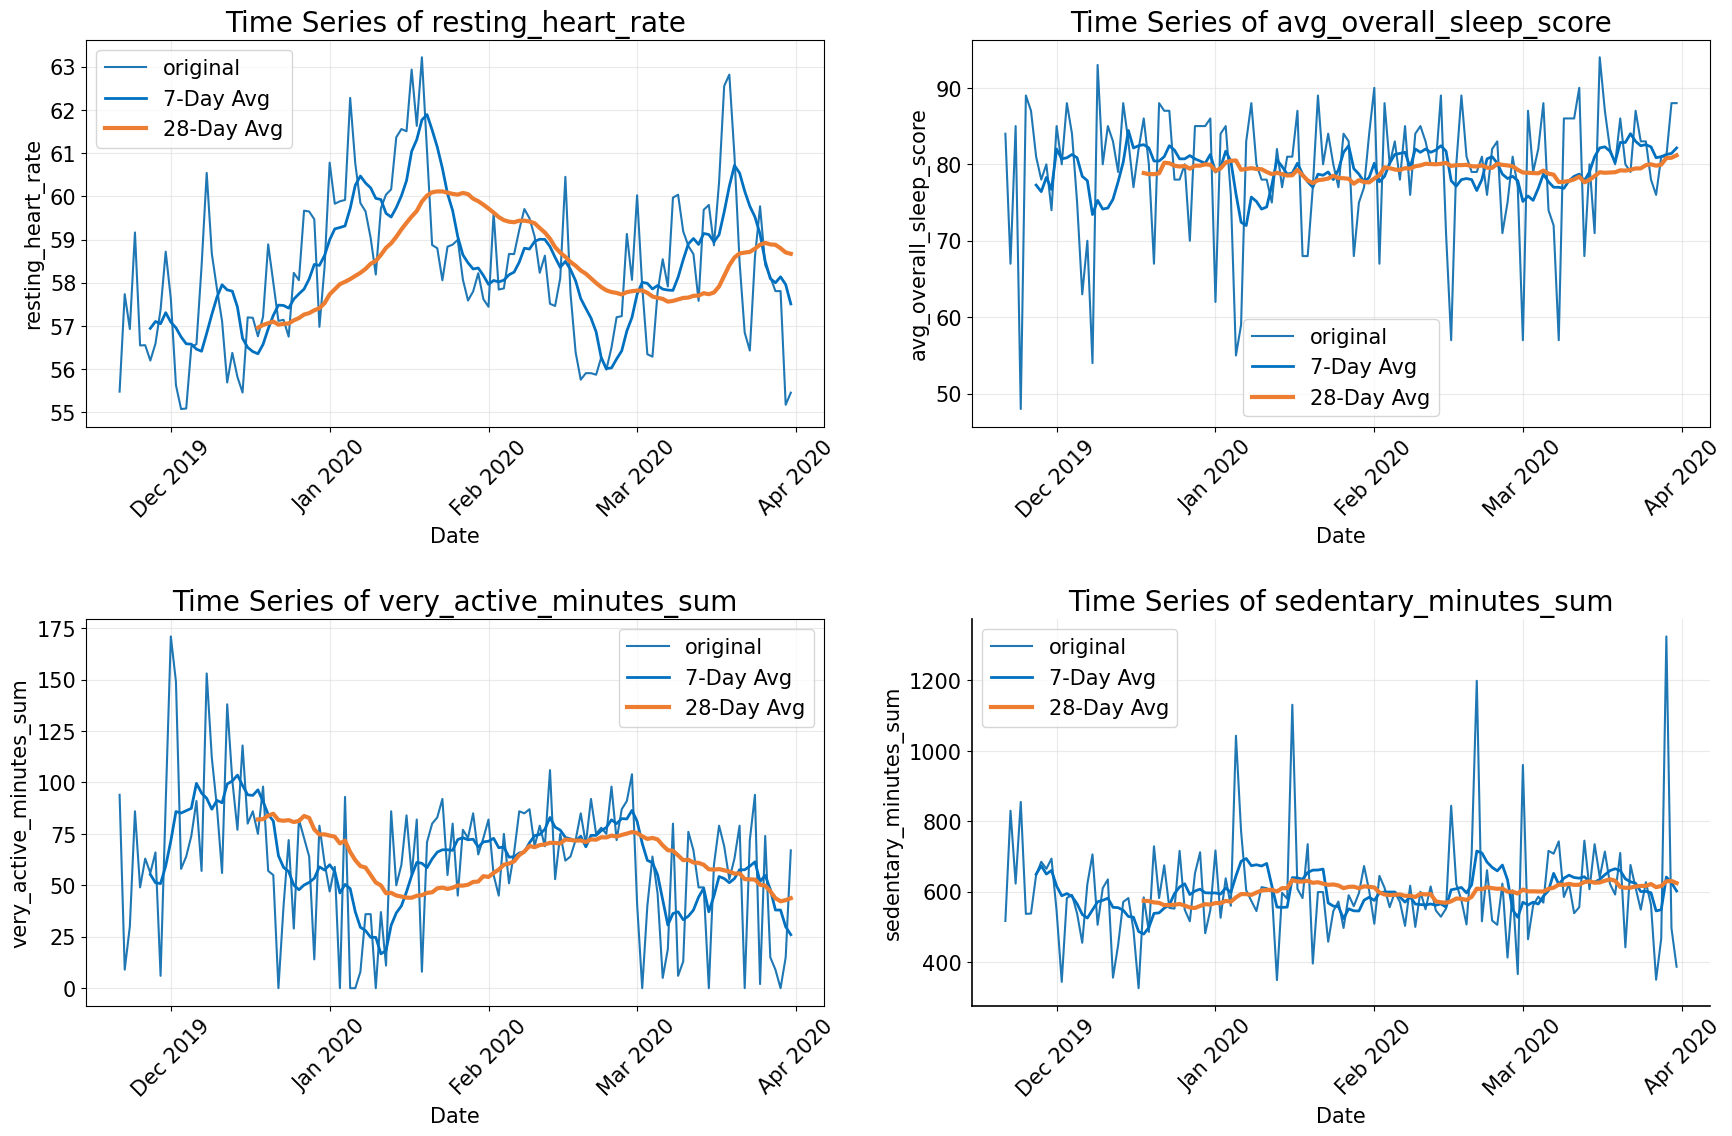

In [4]:
draw_plots_grid(p07.iloc[:,[1,2,7,8]], p07.iloc[:,[1,2,7,8]].columns, figure_size=(18,12),nrows = 2, ncols = 2,tick_fontsize=15, label_fontsize=15, legend_fontsize=15,save_path="./figures/23rdJune2025TimeSeries.png")

Calculate Rolling Baselines: For each student, we need to calculate their personal 30-day rolling baseline (mean and standard deviation) for the physiological metrics.

Calculate rhr_30d_mean and rhr_30d_std for resting_heart_rate.
Calculate sleep_score_30d_mean and sleep_score_30d_std for avg_overall_sleep_score.
Calculate Daily Sub-Scores: Using the baselines, we'll compute the two components of the risk score for each day.

Subjective_Distress_Score (0-4 points): Sum points for negative self-reports (fatigue, mood, stress, sleep_quality scores of 1 or 2).
Physiological_Deviation_Score (0-2 points):
+1 point if resting_heart_rate is more than one standard deviation above its 30-day mean.
+1 point if avg_overall_sleep_score is more than one standard deviation below its 30-day mean.
Calculate Composite Risk Score:

Create a Composite_Risk_Score column by summing the two scores above.
Identify High-Risk State:

Create a binary High_Risk_State column, flagging any day where Composite_Risk_Score >= 3 as 1 and all others as 0.
Engineer the Final Target (Is_High_Risk_Next_7_Days):

This is the final step. For each day, we will look forward into the next 7 days. If a High_Risk_State (1) occurs at any point within that window, we will set Is_High_Risk_Next_7_Days to 1 for the current day. Otherwise, it will be 0.

In [ ]:
create_merged_dfs(participant_id)

In [8]:
df = calculate_rolling_baselines(df, ["resting_heart_rate","avg_overall_sleep_score"], window_size=14, calculate_mean=True, calculate_std=True)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 132 entries, 2019-11-21 to 2020-03-31
Data columns (total 12 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   resting_heart_rate               132 non-null    float64
 1   avg_overall_sleep_score          132 non-null    float64
 2   fatigue                          132 non-null    float64
 3   mood                             132 non-null    float64
 4   stress                           132 non-null    float64
 5   sleep_quality                    132 non-null    float64
 6   very_active_minutes_sum          132 non-null    int64  
 7   sedentary_minutes_sum            132 non-null    int64  
 8   resting_heart_rate_14_mean       132 non-null    float64
 9   resting_heart_rate_14_std        132 non-null    float64
 10  avg_overall_sleep_score_14_mean  132 non-null    float64
 11  avg_overall_sleep_score_14_std   132 non-null    float64
dtypes: 

In [10]:
df.columns

Index(['resting_heart_rate', 'avg_overall_sleep_score', 'fatigue', 'mood',
       'stress', 'sleep_quality', 'very_active_minutes_sum',
       'sedentary_minutes_sum', 'resting_heart_rate_14_mean',
       'resting_heart_rate_14_std', 'avg_overall_sleep_score_14_mean',
       'avg_overall_sleep_score_14_std'],
      dtype='object')

In [11]:
SUBJECTIVE_COLS = ['fatigue', 'mood', 'stress', 'sleep_quality']

PHYSIOLOGICAL_CONFIG = [
    {
        'metric': 'resting_heart_rate',
        'mean': 'resting_heart_rate_14_mean',
        'std': 'resting_heart_rate_14_std',
        'direction': 'above'
    },
    {
        'metric': 'avg_overall_sleep_score',
        'mean': 'avg_overall_sleep_score_14_mean',
        'std': 'avg_overall_sleep_score_14_std',
        'direction': 'below'
    }
]

In [12]:
df = add_risk_scores(df, 
                subjective_cols_config = SUBJECTIVE_COLS,
                physiological_cols_config=PHYSIOLOGICAL_CONFIG)

Successfully calculated and appended daily risk scores using refactored functions.


In [13]:
RISK_THRESHOLD = 3
LOOKAHEAD_DAYS = 7
df = engineer_target_variable(df, risk_threshold=RISK_THRESHOLD, lookahead_window=LOOKAHEAD_DAYS)


In [14]:
df.columns

Index(['resting_heart_rate', 'avg_overall_sleep_score', 'fatigue', 'mood',
       'stress', 'sleep_quality', 'very_active_minutes_sum',
       'sedentary_minutes_sum', 'resting_heart_rate_14_mean',
       'resting_heart_rate_14_std', 'avg_overall_sleep_score_14_mean',
       'avg_overall_sleep_score_14_std', 'Subjective_Distress_Score',
       'Physiological_Deviation_Score', 'Composite_Risk_Score',
       'High_Risk_State', 'Is_High_Risk_Next_7_Days'],
      dtype='object')

In [15]:
X_columns = [
    'resting_heart_rate',
    'avg_overall_sleep_score',
    'fatigue',
    'mood',
    'stress',
    'sleep_quality',
    'very_active_minutes_sum',
    'sedentary_minutes_sum',
    'resting_heart_rate_14_mean',
    'resting_heart_rate_14_std',
    'avg_overall_sleep_score_14_mean',
    'avg_overall_sleep_score_14_std',
]

y_column = 'Is_High_Risk_Next_7_Days'

In [16]:
df_eda = df.iloc[:-7].copy()

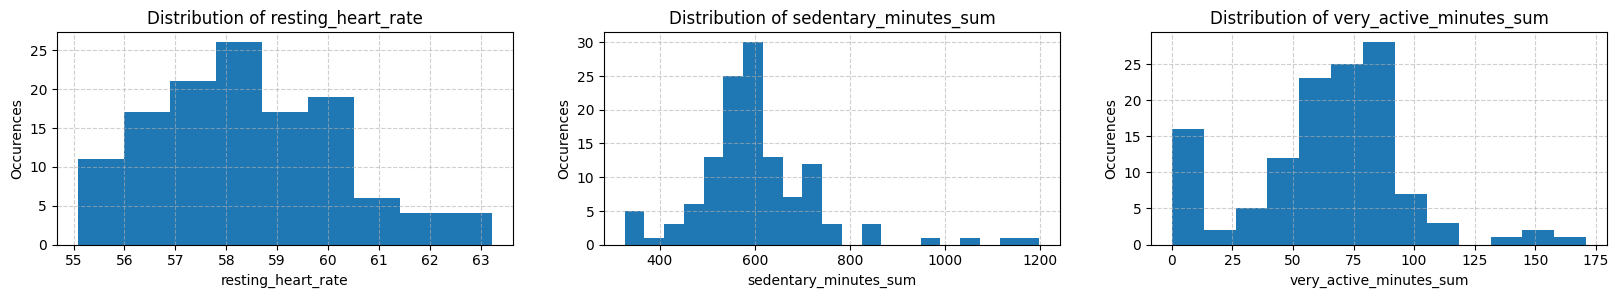

In [17]:
plot_distribution(df_eda, ["resting_heart_rate","sedentary_minutes_sum","very_active_minutes_sum"],type = "hist",nrows=5, ncols=3, save_path="14thJune2025_p07_hist")

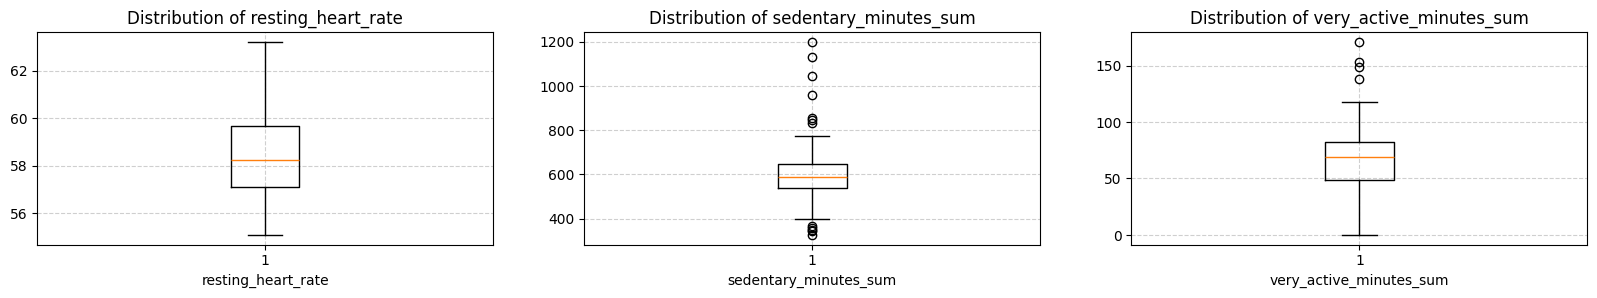

In [18]:
plot_distribution(df_eda, ["resting_heart_rate","sedentary_minutes_sum","very_active_minutes_sum"],type = "box",nrows=5, ncols=3,  save_path="14thJune2025_p07_box")

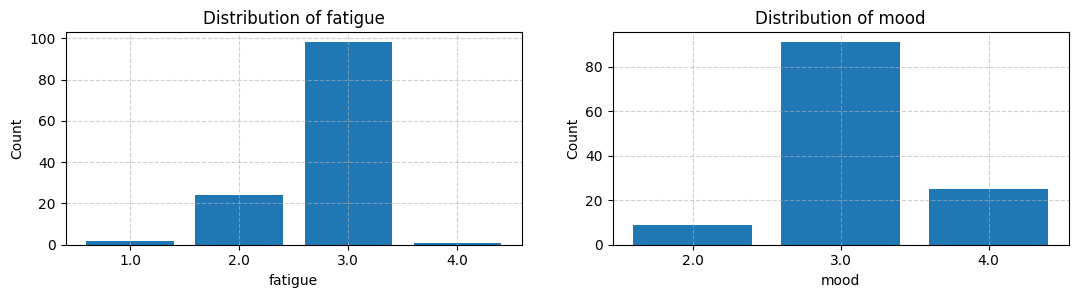

In [19]:
plot_distribution(df_eda, ["fatigue","mood"],type = "bar",nrows=5, ncols=3,  save_path="14thJune2025_p07_bar")

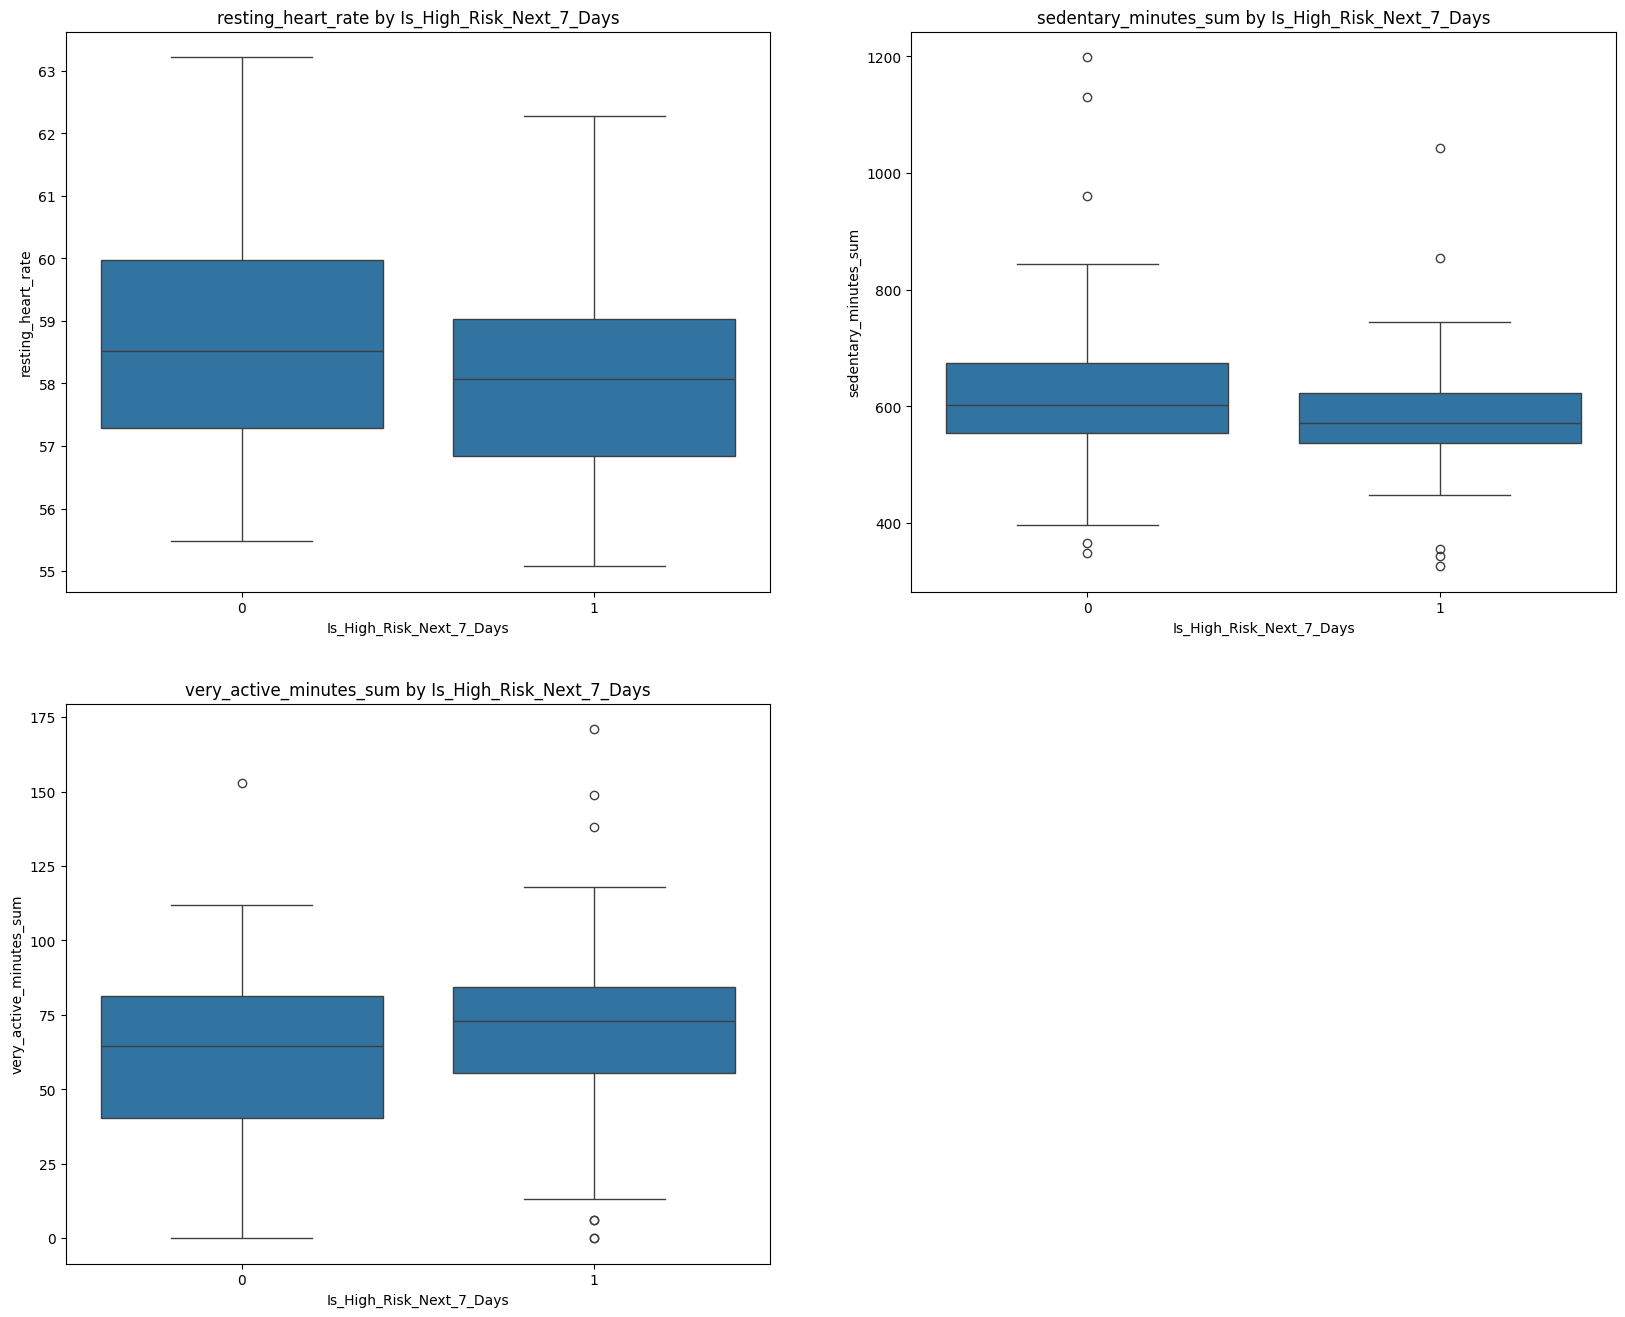

In [20]:
plot_bivariate_distribution(df_eda, columns = ["resting_heart_rate","sedentary_minutes_sum","very_active_minutes_sum"], target = y_column, type = "box",nrows = 2, ncols = 2,  save_path="14thJune2025_p07_bivariate_box")

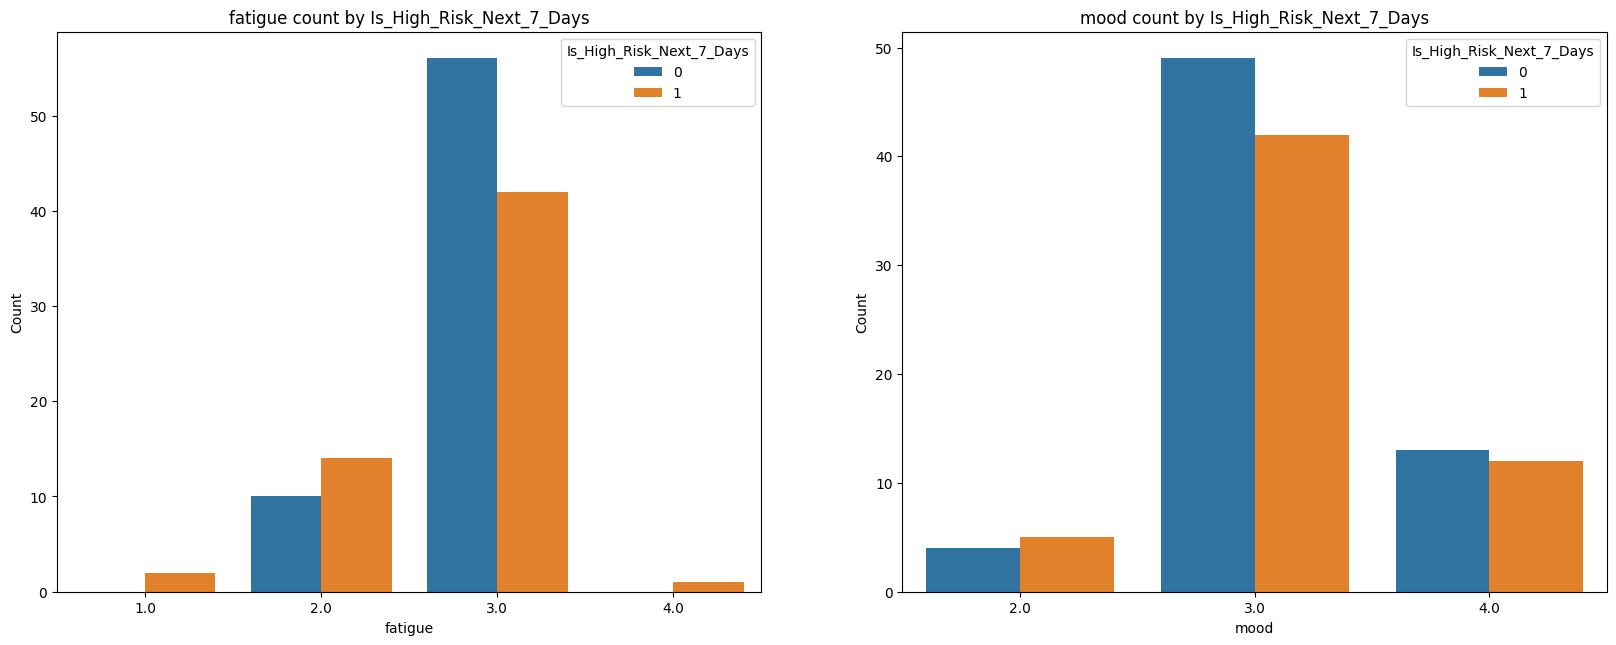

In [21]:
plot_bivariate_distribution(df_eda, ["fatigue", "mood"], target="Is_High_Risk_Next_7_Days", type="bar",  save_path="14thJune2025_p07_bivariate_cluster")


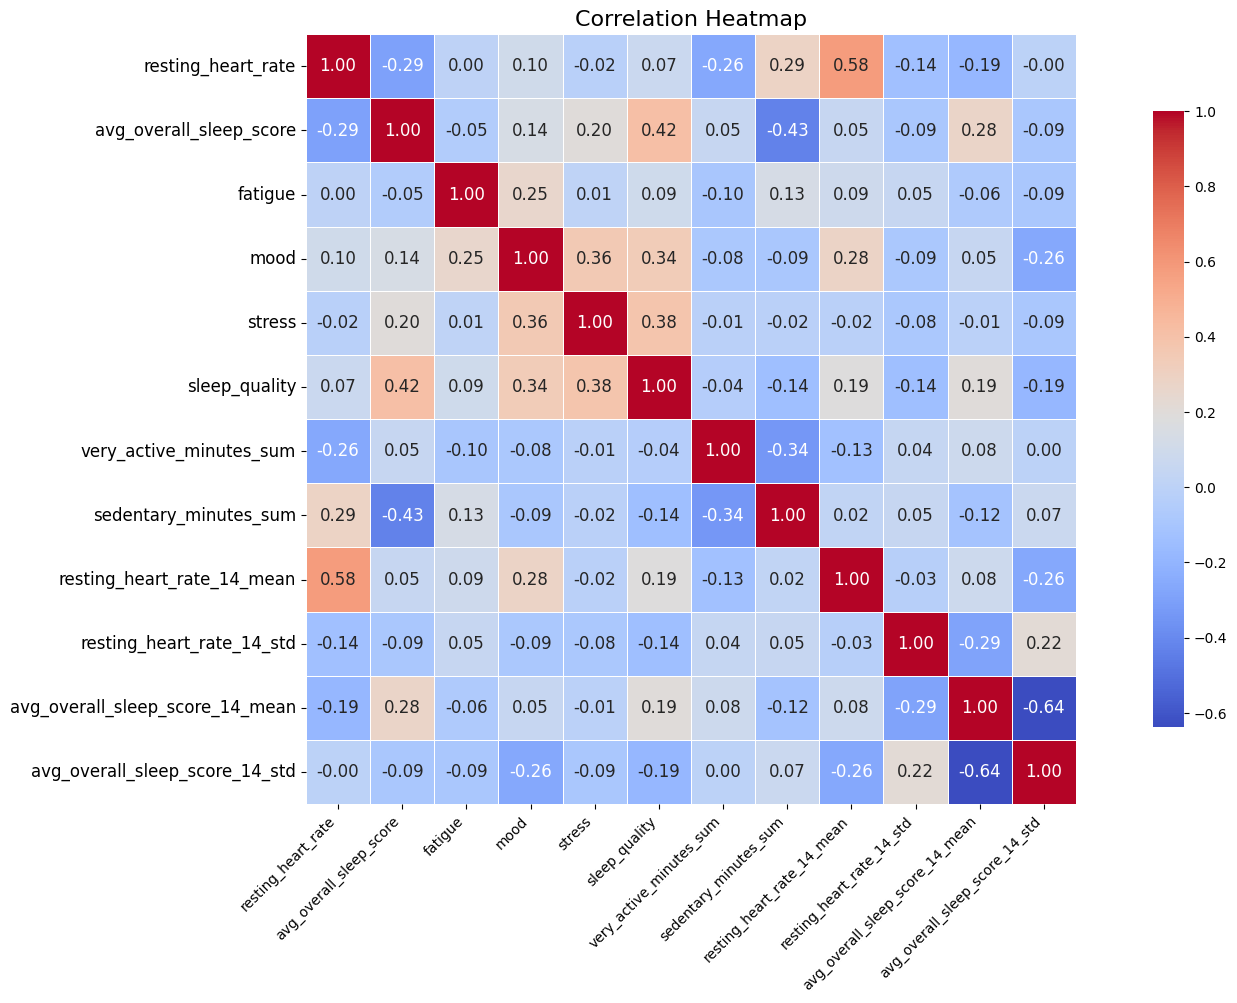

In [22]:
plot_distribution(df_eda, X_columns, type = "heatmap", save_path="14thJune2025_p07_heatmap")

In [23]:
def perform_dickey_fuller_test(series):
    result = adfuller(series)
    print(f"ADF Statistic: {result[0]}")
    print(f"p-value: {result[1]}")
    print("Critical Values:")
    for key, value in result[4].items():
        print(f"  {key}: {value}")

In [24]:
perform_dickey_fuller_test(df_eda['resting_heart_rate'])

ADF Statistic: -4.258908691376373
p-value: 0.0005229038940742054
Critical Values:
  1%: -3.484219653271961
  5%: -2.885145235641637
  10%: -2.579359138917794


In [ ]:
# df_eda.to_csv("./cleaned_data/p07_model_ready.csv", index=True)